In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Import with pandas
# Parse dates and set date column to index
df = pd.read_csv("Eximbank.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,12323.44629,12429.37891,12005.64941,12217.51367,12217.51367,101102
2019-03-04,12217.51367,12711.86426,12146.89258,12570.62109,12570.62109,1698208
2019-03-05,12570.62109,12570.62109,12252.82520,12252.82520,12252.82520,1940443
2019-03-06,12535.31055,12535.31055,12252.82520,12288.13574,12288.13574,40228
2019-03-07,12076.27148,12288.13574,12005.64941,12076.27148,12076.27148,4753044


In [3]:

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1250 entries, 2019-03-01 to 2024-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1250 non-null   float64
 1   High       1250 non-null   float64
 2   Low        1250 non-null   float64
 3   Close      1250 non-null   float64
 4   Adj Close  1250 non-null   float64
 5   Volume     1250 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.4 KB


In [4]:
# Only want closing price for each day
stock_prices = pd.DataFrame(df["Close"])
stock_prices.head()

,Close
Date,
2019-03-01,12217.51367
2019-03-04,12570.62109
2019-03-05,12252.82520
2019-03-06,12288.13574
2019-03-07,12076.27148


In [5]:

# Get bitcoin date array
timesteps = stock_prices.index.to_numpy()
prices = stock_prices["Close"].to_numpy()

timesteps[:10], prices[:10]


(array(['2019-03-01T00:00:00.000000000', '2019-03-04T00:00:00.000000000',
        '2019-03-05T00:00:00.000000000', '2019-03-06T00:00:00.000000000',
        '2019-03-07T00:00:00.000000000', '2019-03-08T00:00:00.000000000',
        '2019-03-11T00:00:00.000000000', '2019-03-12T00:00:00.000000000',
        '2019-03-13T00:00:00.000000000', '2019-03-14T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([12217.51367, 12570.62109, 12252.8252 , 12288.13574, 12076.27148,
        12252.8252 , 12252.8252 , 12500.     , 12570.62109, 12429.37891]))

In [6]:


# Create train and test splits the right way for time series data
split_size = int(0.9 * len(prices)) # 90% train, 10% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1125, 125, 1125, 125)

In [7]:
y_test[:10]

array([21610.16992, 21186.44141, 21440.67773, 22033.89844, 21652.54297,
       21652.54297, 21652.54297, 21610.16992, 21186.44141, 21525.42383])

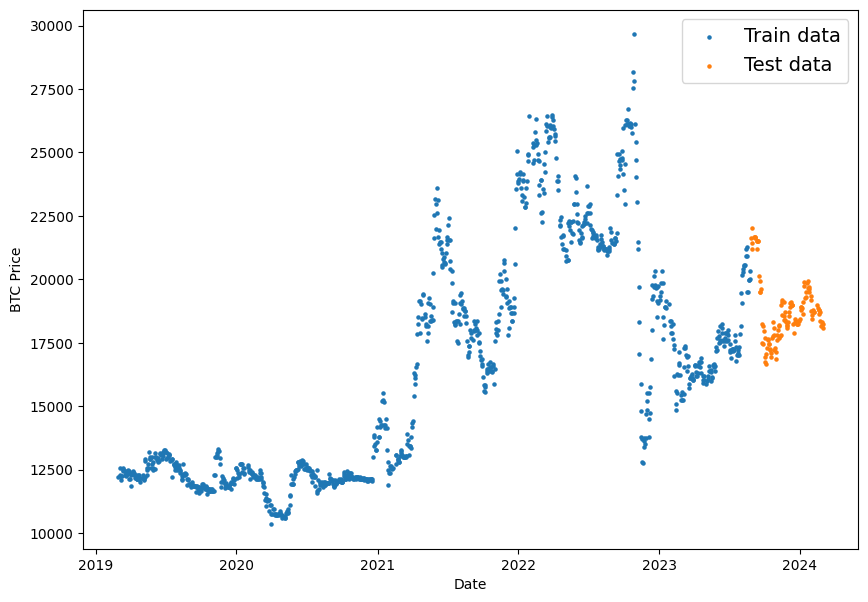

In [8]:

# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [11]:
HORIZON = 1
WINDOW_SIZE = 100

In [12]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [13]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]], dtype=int32)>

In [14]:

# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ -2.1921525   16.618486     6.4987345    2.72012      4.569471
 -12.730583     4.684616     4.863971     3.8573537   21.424236
 -22.258263    -3.0028958   -3.2240484  -27.51668     -9.190384
 -15.922199    14.603551     9.4904175    1.0348754   17.250076
   3.8071814  -16.569992     3.8026674    4.6279135   -8.070574
   7.295251     8.318998     1.6174207   13.670358    -1.60987
  -5.2499123   -5.0755587  -10.469875    20.439209    13.611324
   1.2054757   19.156233     8.530094    -8.890336     5.970008
   1.9831707    1.1750401   -9.637907     6.68532      8.2839985
  -2.2694983  -20.906767   -17.531677     6.286191    11.467989
   3.223216   -15.752247   -13.635676    10.079962    26.21288
  -9.603643     9.2956085    9.859116    -6.8708444   -3.306726
  -4.0047703   -6.1246376    2.2671027   -8.460573    -1.0948197
  -5.5960407    0.41006184   6.579495     4.1893635   -5.463821
   7.9365873    4.7063127    0.20750308  -3.5744848    3.2286658
  -0.34375358  -2.913656   -1

#Preparing data for the N-BEATS algorithm using tf.data
We've got the basic building block for the N-BEATS architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the tf.data API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).

#For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (100 days in the past), the horizon would be 1 and the window would be 100.

In [15]:
HORIZON = 1 #horizon = number of timesteps to predict into future
WINDOW_SIZE = 100 # window = number of timesteps from past used to predict horizon

In [16]:

# Create NBEATS data inputs (NBEATS works with univariate time series)
stock_prices.head()

,Close
Date,
2019-03-01,12217.51367
2019-03-04,12570.62109
2019-03-05,12252.82520
2019-03-06,12288.13574
2019-03-07,12076.27148


In [17]:
# Add windowed columns
bitcoin_prices_nbeats = stock_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Close+{i+1}"] = bitcoin_prices_nbeats["Close"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

<ipython-input-17-fe1bd473b10b>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bitcoin_prices_nbeats[f"Close+{i+1}"] = bitcoin_prices_nbeats["Close"].shift(periods=i+1)


,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7,Close+8,Close+9,...,Close+91,Close+92,Close+93,Close+94,Close+95,Close+96,Close+97,Close+98,Close+99,Close+100
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-25,12605.93262,12676.55371,12711.86426,12711.86426,12923.72852,12217.51367,12923.72852,12888.41797,12888.41797,12853.10742,...,12429.37891,12570.62109,12500.00000,12252.82520,12252.82520,12076.27148,12288.13574,12252.82520,12570.62109,12217.51367
2019-07-26,12464.68945,12605.93262,12676.55371,12711.86426,12711.86426,12923.72852,12217.51367,12923.72852,12888.41797,12888.41797,...,12500.00000,12429.37891,12570.62109,12500.00000,12252.82520,12252.82520,12076.27148,12288.13574,12252.82520,12570.62109
2019-07-29,12782.48633,12464.68945,12605.93262,12676.55371,12711.86426,12711.86426,12923.72852,12217.51367,12923.72852,12888.41797,...,12288.13574,12500.00000,12429.37891,12570.62109,12500.00000,12252.82520,12252.82520,12076.27148,12288.13574,12252.82520
2019-07-30,12676.55371,12782.48633,12464.68945,12605.93262,12676.55371,12711.86426,12711.86426,12923.72852,12217.51367,12923.72852,...,12429.37891,12288.13574,12500.00000,12429.37891,12570.62109,12500.00000,12252.82520,12252.82520,12076.27148,12288.13574
2019-07-31,12676.55371,12676.55371,12782.48633,12464.68945,12605.93262,12676.55371,12711.86426,12711.86426,12923.72852,12217.51367,...,12288.13574,12429.37891,12288.13574,12500.00000,12429.37891,12570.62109,12500.00000,12252.82520,12252.82520,12076.27148


In [18]:
bitcoin_prices_nbeats.shape

(1250, 101)

In [19]:

# Make features and labels
X = bitcoin_prices_nbeats.drop("Close", axis=1)
y = bitcoin_prices_nbeats["Close"]
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)


# Make train and test sets
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1125, 1125, 125, 125)

In [20]:
X.shape

(1250, 100)

In [21]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [22]:

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 800 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(100, 101)

In [23]:
from tensorflow.keras import layers



In [24]:

# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


#Building, compiling and fitting the N-BEATS algorithm
Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
Make the initial backcast and forecasts for the model with the layer created in (1)
Use a for loop to create stacks of block layers
Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
Create the double residual stacking using subtract and add layers
Put the model inputs and outputs together using tf.keras.Model()
Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)
Woah. A bunch of steps. But I'm sure you're up to it.

In [25]:


tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")



In [26]:
# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")



In [27]:
# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

#loss='mean_squared_error'

In [28]:
# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 167: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 267: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [29]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 141ms/step - loss: 455.7437 - mae: 455.7437 - mse: 345494.9062


[455.74371337890625, 455.74371337890625, 345494.90625]

In [30]:

def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [31]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([19999.986, 20230.764, 20351.55 , 20554.879, 20741.588, 21014.709,
       21397.396, 21312.459, 21279.47 , 21169.629], dtype=float32)>

In [32]:

# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [33]:

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  print("Kết quả độ đo RMSE: ", rmse.numpy())
  print("Kết quả độ đo MAE: ", mae.numpy())
  print("Kết quả độ đo MAPE: ", mape.numpy())


In [34]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

Kết quả độ đo RMSE:  587.78815
Kết quả độ đo MAE:  455.7437
Kết quả độ đo MAPE:  2.4255855


In [35]:
# How many timesteps to predict into the future?
INTO_FUTURE = 30 # since our Bitcoin data is daily, this is for 14 days

In [36]:

# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [37]:
# Only want closing price for each day
stock_prices = pd.DataFrame(df["Close"])
stock_prices

,Close
Date,
2019-03-01,12217.51367
2019-03-04,12570.62109
2019-03-05,12252.82520
2019-03-06,12288.13574
2019-03-07,12076.27148
...,...
2024-02-26,18150.00000
2024-02-27,18200.00000
2024-02-28,18300.00000


In [38]:

# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2019-03-01")
block_reward_3_datetime = np.datetime64("2022-03-01")
block_reward_4_datetime = np.datetime64("2024-05-01")

In [39]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - stock_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - stock_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1096, 1888)

In [40]:

# Add block_reward column
bitcoin_prices_block = stock_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block

,Close,block_reward
Date,,
2019-03-01,12217.51367,25
2019-03-04,12570.62109,25
2019-03-05,12252.82520,25
2019-03-06,12288.13574,25
2019-03-07,12076.27148,25
...,...,...
2024-02-26,18150.00000,12.5
2024-02-27,18200.00000,12.5
2024-02-28,18300.00000,12.5


In [41]:

# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)
bitcoin_prices_windowed

<ipython-input-41-29752b4358d1>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)
<ipython-input-41-29752b4358d1>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)


,Close,block_reward,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7,Close+8,...,Close+91,Close+92,Close+93,Close+94,Close+95,Close+96,Close+97,Close+98,Close+99,Close+100
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-01,12217.51367,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-04,12570.62109,25,12217.51367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-05,12252.82520,25,12570.62109,12217.51367,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-06,12288.13574,25,12252.82520,12570.62109,12217.51367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-07,12076.27148,25,12288.13574,12252.82520,12570.62109,12217.51367,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,18150.00000,12.5,18350.00000,18700.00000,18800.00000,18650.00000,18800.0,18850.0,19000.0,18700.0,...,17600.0,17300.0,17050.0,16650.0,16950.0,16750.0,17700.0,17950.0,17450.0,18150.0
2024-02-27,18200.00000,12.5,18150.00000,18350.00000,18700.00000,18800.00000,18650.0,18800.0,18850.0,19000.0,...,17650.0,17600.0,17300.0,17050.0,16650.0,16950.0,16750.0,17700.0,17950.0,17450.0
2024-02-28,18300.00000,12.5,18200.00000,18150.00000,18350.00000,18700.00000,18800.0,18650.0,18800.0,18850.0,...,17450.0,17650.0,17600.0,17300.0,17050.0,16650.0,16950.0,16750.0,17700.0,17950.0


In [42]:
y_all = bitcoin_prices_windowed.dropna()["Close"].to_numpy()


In [43]:

# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_7,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 3s 3s/step
Predicting on: 
 [16950. 16650. 17050. 17300. 17600. 17650. 17450. 17450. 17250. 17200.
 16950. 17100. 17700. 17750. 18300. 18100. 17200. 17800. 17300. 16850.
 17150. 17600. 17800. 18000. 17700. 18200. 18150. 17750. 17800. 19000.
 19200. 19100. 18600. 18400. 18550. 19100. 18400. 18700. 18300. 18150.
 18100. 18200. 18300. 18700. 18550. 18900. 19050. 19100. 19000. 19000.
 19000. 18250. 17900. 18300. 18450. 18300. 18300. 18250. 18250. 18250.
 18350. 18350. 18450. 18800. 18900. 18900. 18850. 18650. 19100. 19900.
 19750. 19250. 19500. 19300. 19850. 19950. 19650. 19600. 19700. 19500.
 19200. 19350. 18750. 18600. 18450. 18800. 18700. 18700. 19000. 18850.
 18800. 18650. 18800. 18700. 18350. 18150. 18200. 18300. 18100. 18250.] -> Prediction: 17352.259765625

1/1 [==============================] - 0s 56ms/step
Predicting on: 
 [16650.         17050.         17300.         17600.
 17650.         17450.         17450.         17250.
 17200.        

#VẼ HÌNH

In [44]:
# Only want closing price for each day
stock_prices = pd.DataFrame(df["Close"])
stock_prices.head()

prices = stock_prices["Close"].to_numpy()

# Create train data splits (everything before the split)
y_train = prices[:split_size]

# Create test data splits (everything after the split)
y_test = prices[split_size:]
len(y_train), len(y_test)

(1125, 125)

In [45]:
test_size = len(df)-split_size
test_size

125

In [46]:
# Chuyển đổi thành NumPy array
future_forecast_array = np.array(future_forecast)

# Reshape thành mảng 2 chiều với shape (30, 1)
future_forecast_reshaped = future_forecast_array.reshape((30, 1))

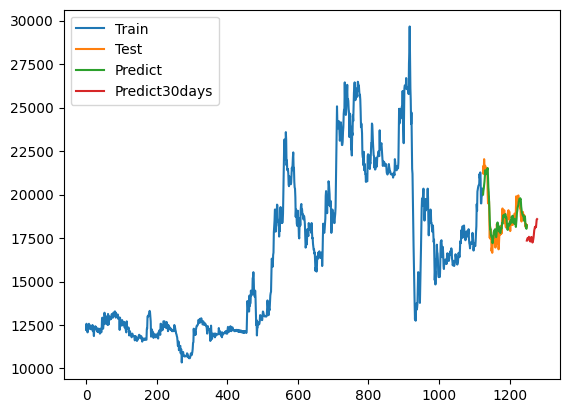

In [47]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)

test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,model_7_preds)

prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [48]:
future_forecast_array

array([17352.26 , 17427.213, 17489.43 , 17472.902, 17411.482, 17458.059,
       17571.326, 17474.238, 17419.11 , 17310.18 , 17467.658, 17309.6  ,
       17544.812, 17454.756, 17542.756, 17449.943, 17239.67 , 17295.947,
       17388.484, 17519.041, 17711.69 , 17940.217, 18029.018, 18137.656,
       18094.895, 18173.441, 18125.639, 18350.057, 18565.213, 18588.066],
      dtype=float32)

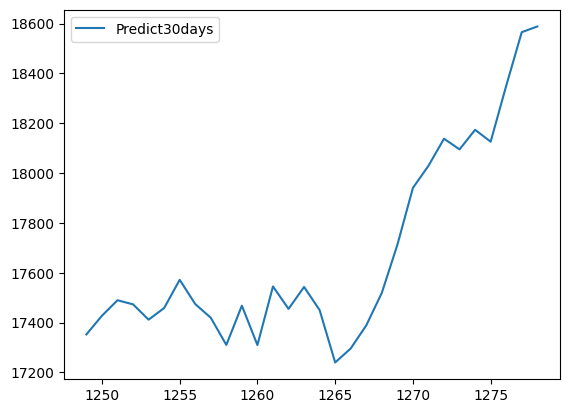

In [49]:
# 14.Vẽ hình
# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.legend(['Predict30days'])
plt.show()